#Project 2 : Hidden Markov models and optimal control
Authors : Simon Vandergooten and Clémence Vandamme.

In this second project, you will implement a Hidden Markov Model with 3 states and apply to your posterior probabilities optimal control. In other words, based on your knowledge and uncertainties, you will decide the optimal actions you need to take in any situation.

##Context :
The belgian government is trying to develop a new strategy to differentiate between patients with hypertension and those with hypotension in order to help preventing fainting and cardiac arrest.

Patients can be in one of the three following states : healthy, hypertension or hypotension. The patient's health status is represented by the vector $S$, where each value $s_t$ represents the patient's status in day $t$. The government also provides you the transition probabilities between each state, based on data from the national public health department.

You received the blood pressure measurements of a patient for 150 days. Those measurements are made with a new state-of-the-art tool. However, he design of this tool is not yet perfected and the measurements are for the moment very imprecise. Based on these data, you are asked to provide an estimate of the true state of the patient. 

Furthermore, two drugs are available on the market. One aims to lower the blood pressure, the other increases it. At each moment, you need to determine if you should take a drug and which one. However, take into account that these drugs have a cost and that taking a drug when healthy represents a risk to make the situation worse.  

##Practical information:
### HMM

The following graph sums up the different states and their transition probabilities. **The initial state is healthy**.

<img alt='Solution hint' align='center' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/Projet2_bis.png> 

\\

### Measurements

Concerning the measurements $m_t$, the systolic blood pressure levels are distributed as follow:

* $m_t \sim \mathcal{N}$(120, $\sigma_{healthy}^2$) if $s_t$ = 'healthy'.

* $m_t \sim \mathcal{N}$(160, $\sigma_{hyper}^2$) if $s_t$ = 'hyper'.

* $m_t \sim \mathcal{N}$(80, $\sigma_{hypo}^2$) if $s_t$ = 'hypo'.

Where $\sigma_{healthy}, \, \sigma_{hyper}, \, \sigma_{hypo}=27, \, 30\, , 28$  are the measurement noise related to the new tool.
 

\\
### Potential actions and their effects

Each day, you have 3 options:
- Take a drug A
    - It has 80% chances to **lower** your tension to 120 if you suffer from **hypertension**. (Therefore, 20% chances to have no effect). 
    - It has 40% chance to **lower** your tension to 80 if you were **healthy**. 
    - It has **no effect** if you suffer from **hypotension**.

- Take a drug B 
    - It has 80% chances to **increase** your tension to 120 if you suffer from **hypotension**.
    - It has 40% chances to **increase** your tension to 160 if you were **healthy**.
    - It has **no effect** if you suffer from **hypertension**.

- Do nothing: no effect on your blood pressure in any state. 

NOTE : The action has no impact on the state transition and the state itself. It should only be the most appropropriate action based on your belief about the state.

\\
### Utility and cost
Utility values associated to blood pressure: 
- 120 mmHg : U = +2
- 160 mmHg : U = -2 (risk of heart attack)
- 80 mmHg : U = -1 (risk of fainting) 

Costs:
- Drug A : 2
- Drug B : 2







## Guidelines 

**READ THIS PART CAREFULLY**

For the first part of the project, you are asked to estimate the posterior probability of each state at any time, based on the measurements vector M and on the transition probabilities. M contains 150 measurements. Then, graphically represent the evolution of these probabilities. The way you plot these data are up to you, make it readable and interpretable (you do not necessarily have to represent all the time step). 


In the second part, determine the policy you will follow at each time step to choose the optimal action. Based on this policy, return the vector of actions taken for the given data. A policy must be optimal in the sense that it maximizes the benefit (utility) and minimizes the cost. It simply consists in setting a threshold on your posterior belief. For example, "*if I have more than 65% probability to have hypertension, I will take drug A*" is a policy. We give you the 100 first true states to test different policies (i.e, different thresholds) and determine which one is the best. Indeed, with the true states, you can determine the impact of your actions and compute both the benefit and the cost. 
After finding your optimal policy, you can look at the actions chosen for your measures for which you do not have the true states (i.e the last 50 measurements).


Finally, discuss the impact of some relevant parameters of the model. For exemple, what do you observe in the policy and selected actions if the cost of both drugs increase ? 


\\
###To sum up:

1) Create your HMM and compute the posterior probabilities associated to each state based on the measurements. 

2) Graphically represent the evolution of the posteriors.

3) Define an optimal policy (this answer must appear clearly).  

4) Based on your policy, determine the drug to take at each time step for the given data. 

5) Discuss the impact of the parameters of the model on the policy and the resulting actions. 


###Data:

- The vector $S$ containing the 100 first hidden states $s_t$: 
  * $s_t$ = 'healthy' if the patient's state is healthy for day $t$ 
  * $s_t$ = 'hyper' if the patient's state is hypertension for day $t$ 
  * $s_t$ = 'hypo' if the patient's state is hypotension for day $t$ 

  It must be only used to determine the optimal policy. **It cannot be used for the HMM**. 

- The vector $M$ containing 150 measurements $m_t$. It is a vector of scalars. 

###Submission
Like for the first project, you must submit your notebook with all your answers. \\
The **deadline is the Thurday 25 November 23:59**. Name your notebook as follow : "LGBIO2060_Projet2_Grxx". \\
Don't forget to register for a timeslot for the oral evaluation.

# **Section 1: Importation des données**




In [35]:
#import libraries
import numpy as np
import pandas as pd 
import io
import time
import colorsys
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolor
from scipy import stats
import matplotlib.patches as patches
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import linear_sum_assignment
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib import pyplot as plt
from IPython.display import Markdown, display, Image
from sklearn.linear_model import LinearRegression
def printmd(string):
    display(Markdown(string))
%matplotlib inline

In [36]:
# Sélection des fichiers sur l'ordinateur
from google.colab import files
uploaded = files.upload()

Saving M.csv to M (1).csv
Saving S_training.csv to S_training (1).csv


In [37]:
# Stockage des données
M = pd.read_csv(io.BytesIO(uploaded['M.csv'])).to_numpy()[:,1:]
S_training = pd.read_csv(io.BytesIO(uploaded['S_training.csv'])).to_numpy()[:,1:]

# **Section 2 : Résolution du problème**

**1. Création du HMM et calcul des probabilités postérieures associées à chaque état, sur base des mesures**

In [38]:
# Etablissement des données
T = np.array([[0.3, 0.4, 0.4], [0.25, 0.65, 0.1], [0.6, 0.1, 0.3]])  #matrice de transition comprenant les probabilités de transitions entre états
means = np.array([120, 160, 80])            #tableau reprenant la moyenne de la distribution pour chaque état (sain, hypertension, hypotension)
var = np.array([27**2, 30**2, 28**2])       #tableau reprenant les variances de la distribution pour chaque état
start_proba = np.array([1, 0, 0])           #initialisation du premier état comme étant sain
measurement = M.T                           #vecteur ligne de toutes les colonnes
measurements = measurement[0]

def compute_likelihood(means, var, M):
  """
  Fonction calculant le likelihood pour toutes les mesures
  Arguments: 
    means (array): tableau reprenant la moyenne pour chaque état
    var (array): tableau reprenant la variance pour chaque état 
    M (numpy vector) : reprend les mesures
  
  Retourne: le likelihood L (numpy array)
   """
  #Initialisation des distributions
  p_sain = stats.norm(means[0], np.sqrt(var[0]))
  p_hyper = stats.norm(means[1], np.sqrt(var[1]))
  p_hypo = stats.norm(means[2], np.sqrt(var[2]))
  
  #Extraction du likelihood à partir du pdf
  L = np.stack([p_sain.pdf(M), p_hyper.pdf(M), p_hypo.pdf(M)])
  return L

In [39]:
def one_step_update(T, posterior_tm1, M_t, means, var):
  """ 
  Calcule les update du posterieur pour à chaque fois un pas de temps, sur base du modèle HMM
  Arguments:
    T (numpy array): matrice de transition du HMM
    posterior_tm1 (numpy vector): Posterieur au temps t-1
    M_t (numpy array): mesure au temps t
    means (array): tableau reprenant la moyenne pour chaque état
    var (array): tableau reprenant la variance pour chaque état

  Retourne:
    prediction (numpy array): prediction au temps t (=prior d'aujourd'hui)
    likelihood (numpy array): likelihood de voir M_t pour tous les modèles de mesures
    posterior_t (numpy array): posterieur au temps t
  """
  #Calcul des probabilités prédictives(prior)
  prediction = posterior_tm1 @ T

  #Obtention du likelihood
  likelihood = compute_likelihood(means, var, M_t)

  #Calcul du postérieur
  posterior_t = likelihood * prediction

  #Normalisation
  posterior_t = posterior_t/np.sum(posterior_t)

  return prediction, likelihood, posterior_t

In [40]:
def simulate_forward_inference(means, var, T, start_proba, N, data):
  """
  Cette fonction calcule les prédictions postérieures marginales de x_t pour N-1 temps
  se basant sur les données probantes selon le modèle HMM

  Arguments:
    means (array): tableau reprenant la moyenne pour chaque état
    var (array): tableau reprenant la variance pour chaque état
    T (numpy array): matrice de transition pour le HMM 
    startProba (numpy array): probabilités initiales d'être dans chaque état [p_sain, p_hyper, p_hypo]
    N (int): longueur des vecteurs retournés
    data (numpy array): vecteur des mesures

  Retourne:
    predictive_probs (numpy array): matrice des probabilités predictives 
    likelihoods (numpy array): matrice des likelihoods
    posterior_probs (numpy array): matrice des probabilités postérieures  
  """
  
  #Initialisation des arrays
  predictive_probs = np.zeros((N,3))
  likelihoods = np.zeros((N,3))
  posterior_probs = np.zeros((N,3))
  
  #Calcul marginal pour chaque état latent
  #On commence avec les premiers éléments
  predictive_probs[0,:] = start_proba
  likelihoods[0,:] = compute_likelihood(means, var, data[0,0])
  posterior_probs[0,:] = predictive_probs[0,:] * likelihoods[0,:]
  posterior_probs[0,:] = posterior_probs[0,:]/np.sum(posterior_probs[0,:])

  #On itère pour le reste des N éléments
  for t in range(1, N):
    predictive_probs[t,:], likelihoods[t,:], posterior_probs[t,:] = one_step_update(T, posterior_probs[t-1], data[t,0], means, var)
  return predictive_probs, likelihoods, posterior_probs

# Set random seed
np.random.seed(54)

# Paramètres
N = 150
measurements = (pd.read_csv(io.BytesIO(uploaded['M.csv'])).to_numpy()[:,1:])

#Calcul des différents éléments en appelant les fonctions
predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(means, var, T, start_proba, N, measurements)


**2. Représentations graphiques de l'évolution des postérieurs**

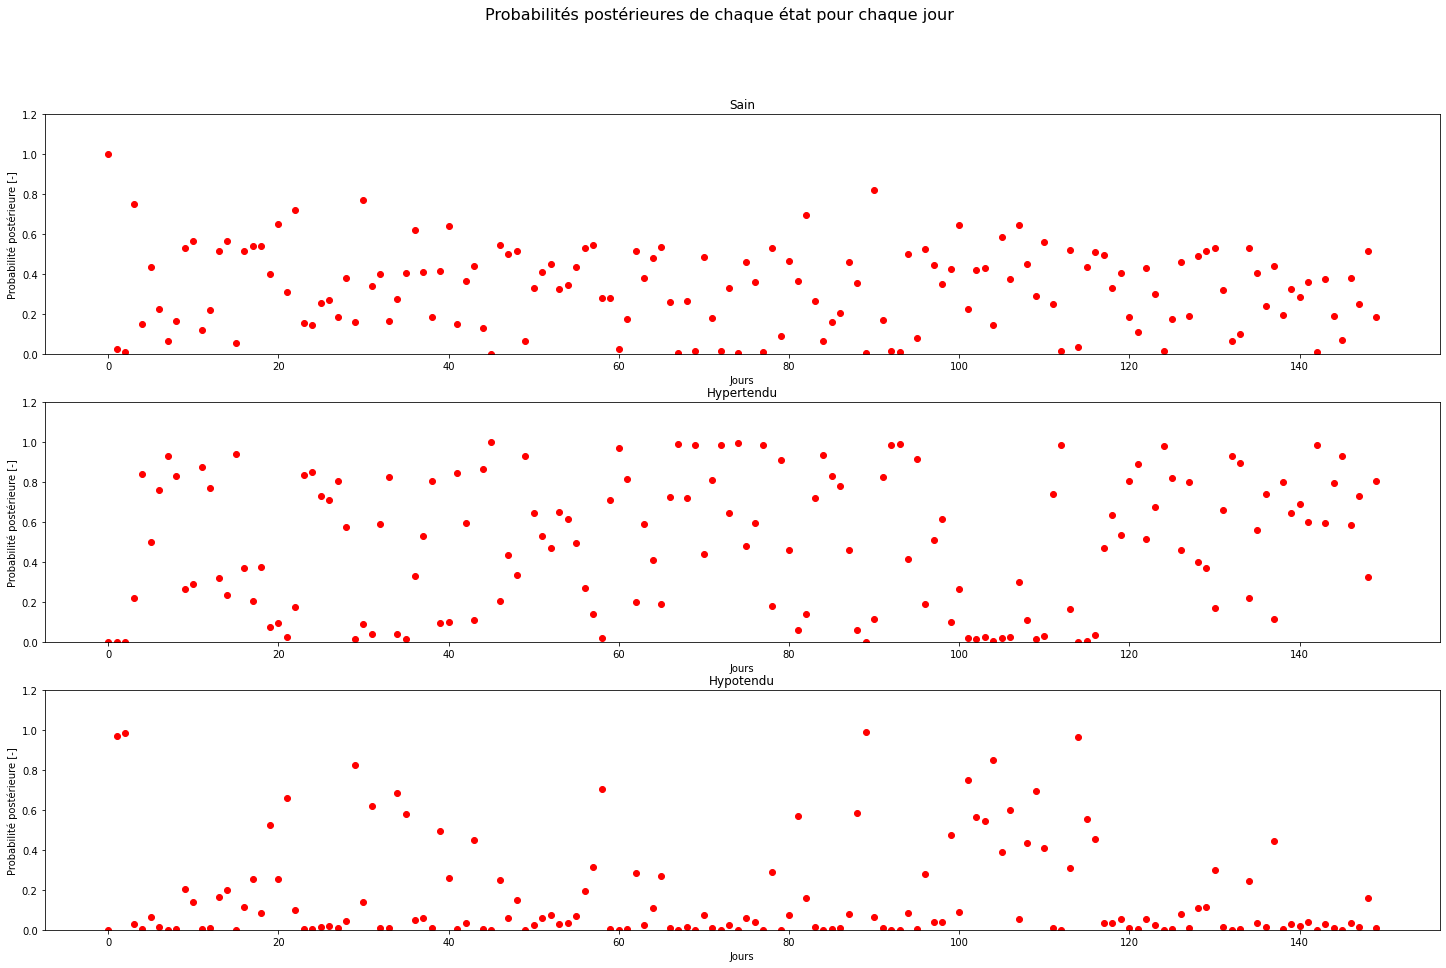

In [41]:
#Génération des graphiques de postérieurs calculés

days = np.arange(0, 150, 1)

fig = plt.figure(1,figsize=(25,15))
fig.suptitle('Probabilités postérieures de chaque état pour chaque jour', fontsize=16)

ax1=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2)
ax3=fig.add_subplot(3,1,3)

ax1.set_title("Sain")
ax1.set_ylabel('Probabilité postérieure [-]')
ax1.set_xlabel('Jours')
ax1.set_ylim(0,1.2)
ax1.scatter(days, posterior_probs[:,0], color='r')

ax2.set_title("Hypertendu")
ax2.set_ylabel('Probabilité postérieure [-]')
ax2.set_xlabel('Jours')
ax2.set_ylim(0,1.2)
ax2.scatter(days, posterior_probs[:,1], color='r')

ax3.set_title("Hypotendu")
ax3.set_ylabel('Probabilité postérieure [-]')
ax3.set_xlabel('Jours')
ax3.set_ylim(0,1.2)
ax3.scatter(days, posterior_probs[:,2], color='r')

Ces graphes nous donnent une idée globale des postérieurs obtenus pour chaque état pour chaque jour. On peut voir que gloablement, la probabilité que le patient soit hypotendu est plus faible que celle d'être hypertendu ou sain. En effet, la majorité des probabilités postérieures se trouvent entre à peu près 0 et 0.4. Concernant l'état hypertendu, on remarque que les probabilités sont généralement plus élevées. On voit effectivement qu’il y a pas mal de points situés entre 0.5 et 1. Cependant, étant donné que ces graphiques ne sont pas aisément lisibles et comparables, nous allons sélectionner uniquement certains jours à intervalles réguliers afin d'avoir une évolution des postérieurs pour chaque état sur un graphe commun.

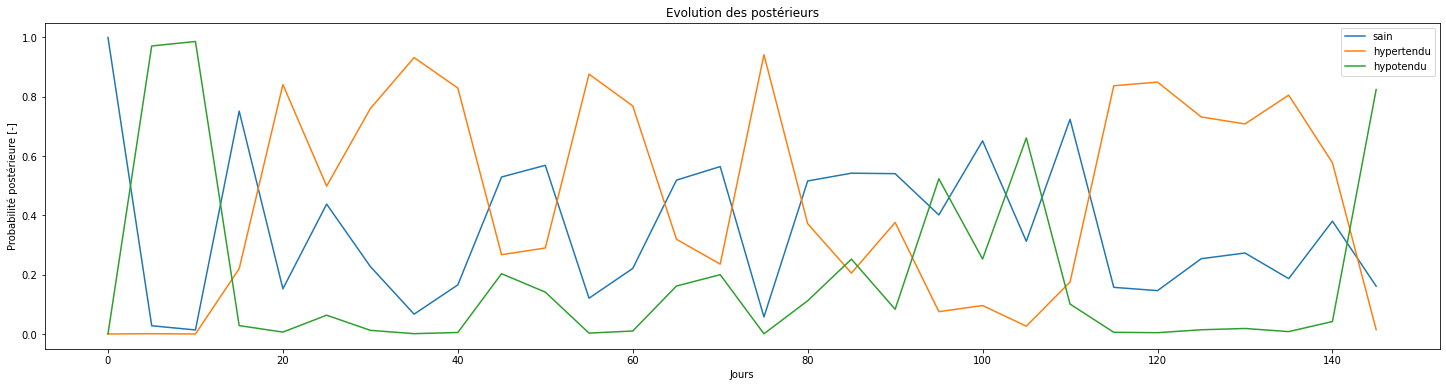

In [42]:
#Plot du graphe reprenant les 3 courbes de postérieurs calculés en même temps

selection = np.arange(0,150,5)      #on sélectionne une donnée tous les 5 pas de temps
xsain = np.zeros(len(selection))
xhyper = np.zeros(len(selection))
xhypo = np.zeros(len(selection))

for i in range(len(selection)):     #création des vecteurs reprenant les postérieurs de chaque état tous les 5 pas de temps
  xsain[i] = posterior_probs[i][0]
  xhyper[i] = posterior_probs[i][1]
  xhypo[i] = posterior_probs[i][2]

#plot du graphe
fig = plt.figure(1,figsize=(25,6))
ax = fig.add_subplot(111)
plt.plot(selection, xsain, label='sain')
plt.plot(selection, xhyper, label='hypertendu')
plt.plot(selection, xhypo, label='hypotendu')
ax.set_title('Evolution des postérieurs')
ax.set_xlabel('Jours')
ax.set_ylabel('Probabilité postérieure [-]')
plt.legend()
plt.show()

Ce graphique représente l'évolution de l'état présumé du patient (basé sur nos postérieurs) tous les 5 jours. Sur ce graphe, on peut voir que la courbe orange (représentant les probabilités postérieures de l'état hypertendu) est régulièrement supérieure aux deux autres états (14 fois sur 30). Par ailleurs, la courbe représentant la probabilité postérieure que le patient soit hypotendu est généralement la plus basse (seulement 5 fois sur 30 supérieure aux probabilités d'être sain ou hypertendu et 22 fois la probabilité la plus faible sans compter la probabilité initiale au temps 0). On peut supposer que l'état du patient ne sera pas souvent hypotendu mais oscillera plus fréquemment entre sain et hypertendu.

**3. Définition d'une politique optimale et détermination des médicaments à prendre**

Le but maintenant est de déterminer les seuils à partir desquels on considérera que le patient est hypertendu ou hypotendu afin de le traiter au mieux. Sur base de cela, on pourra déterminer s'il faut lui administrer un médicament ou non, et si oui, lequel.


Cela signifie donc: 
*   Si probabilité hyper > x% : on considère que le patient souffre d'hypertension et on lui donne le médicament A 
*   Si probabilité hypo > y% : on considère que le patient souffre d'hypotension et on lui donne le médicament B


Afin de déterminer au mieux ces seuils (et donc la politique), nous allons comparer les probabilités postérieures obtenues ci-dessus avec le vecteur des états réels S pour les 100 premiers jours (jours pour lesquels nous avons accès aux états réels). Le but sera de maximiser l'utilité et de minimiser le coût, ce qui revient à maximiser la différence entre l'utilité et le coût. Ceci nous permettra de définir une politique optimale applicable aux 50 derniers jours (pour lesuqels nous n'avons pas accès aux états réels).

In [43]:
#Etablissement des différents seuils
def action(n, posterior, seuilA, seuilB):
  """
  Retourne un vecteur reprenant les actions prises à chaque pas de temps en se basant sur les seuils
  pour décider de l'administration ou non d'un médicament (0 = pas de médicament administré, 1 = administration 
  du médicament A pour l'hypertension, -1 = administration du médicament B pour l'hypotension)

  Arguments:
    n (float): nombre de jours
    posterior (numpy array): arrays de probabilités postérieures
    seuilA (float): seuil choisi pour l'hypertension 
    seuilB (float): seuil choisi pour l'hypotension

  Returns:
    actions (numpy array): vecteur reprenant les actions prises à chaque pas de temps
    sous la forme de numéros (0 = pas de médicament administré, 1 = administration du 
    médicament A pour l'hypertension, -1 = administration du médicament B pour l'hypotension) 
  """
  actions = np.zeros(n)
  i=0
  for i in range(n):
      if posterior[i, 1] > seuilA:   #hypertendu
        actions[i] = 1               #on donne le medicament A
      elif posterior[i, 2] > seuilB: #hypotendu
        actions[i] = -1              #on donne le médicament B
      else:
        actions[i] = 0               #on ne donne rien (patient considéré sain)
  return actions


def utilityandcost(S,n,posterior,seuilA,seuilB):
  """
  Pour chaque pas de temps, compare nos actions (prendre un médicament ou non) avec 
  le vecteur des états réels S. La fonction crée alors un vecteur qui reprend
  l'utilité à chaque pas de temps et calcule le coût pour des seuils définis.

  Arguments:
    S (numpy array): vecteur des états réels pour chaque pas de temps
    n (float): nombre de jours
    posterior (numpy array): arrays de probabilités postérieures
    seuilA (float): seuil choisi pour l'hypertension 
    seuilB (float): seuil choisi pour l'hypotension

  Returns:
    utility (numpy array): vecteur reprenant l'utilité de la politique choisie
    à chaque pas de temps 
    cost (float): coût de cette politique 
  """
  utility= np.zeros(n)
  cost=0
  drug = action(n, posterior,seuilA,seuilB)
  for i in range (len(S)):
    if S[i] == 'healthy':           #si l'état réel est sain
      if drug[i] == 0:              #si on n'a pas administré de drogue, 
        utility[i] = 2              #l'utilité augmente de 2, le coût ne change pas
      elif drug[i] == 1:            #si on a administré le médicament A,  
        utility[i] = 0.6*2 -1*0.4   #60% de chance que la tension ne change pas mais 40% de chance que la tension chute 
        cost+=2                     #le coût augmente car administration d'un médicament
      else:                         #si on a administré le médicament B,
        utility[i] = 0.6*2 - 0.4*2  #60% de chance que la tension ne change pas mais 40% de chance que la tension augmente 
        cost+=2                     #le coût augmente car administration d'un médicament

    elif S[i] == 'hyper':           #même raisonnement si l'état réel est hypertendu
      if drug[i] == 0:
        utility[i] = -2
      elif drug[i] == 1:
        utility[i] = 0.8*2 - 0.2*2 
        cost+=2
      else:
        utility[i] = -2
        cost+=2

    else:                           #même raisonnement si l'état réel est hypotendu
      if drug[i] == 0:
        utility[i] = -1
      elif drug[i] == 1:
        utility[i] = -1
        cost+=2
      else:
        utility[i] = 0.8*2 - 0.2*1
        cost+=2

  return utility, cost


def compare_policies(n, S, posterior, seuilA1, seuilB1, seuilA2, seuilB2):
  """
  Cette fonction compare les valeurs d'utilité et de coût pour différents seuils A et B

  Arguments:
    S (numpy array): vecteur des états réels pour chaque pas de temps
    n (float): nombre de jours
    posterior (numpy array): arrays de probabilités postérieures
    seuilA1 (float): premier seuil choisi pour l'hypertension 
    seuilB1 (float): premier seuil choisi pour l'hypotension
    seuilA2 (float): deuxième seuil choisi pour l'hypertension 
    seuilB2 (float): deuxième seuil choisi pour l'hypotension

  Retourne:
    un seuilA (float): retourne le seuil pour l'hypertension donnant la meilleure utilité  
    un seuil B (float): retourne le seuil pour l'hypotension donnant la meilleure utilité  
    totalutilityandcost (float): utilité de la meilleure politique (soustraction du coût
    à l'utilité pour choisir la politique optimale)
    cost (float): coût de la politique optimale 
  """
  utility1, cost1 = utilityandcost(S,n,posterior,seuilA1,seuilB1)
  utility2, cost2 = utilityandcost(S,n,posterior,seuilA2,seuilB2)

  totalutilityandcost1 = np.sum(utility1) - cost1   #tous les éléments du vecteur utilité sont sommés, de plus on soustrait les coûts puisque ceux-ci doivent être minimisés et l'utilité maximisée
  totalutilityandcost2 = np.sum(utility2) - cost2

  if totalutilityandcost1 > totalutilityandcost2:
    return seuilA1, seuilB1, totalutilityandcost1, cost1
  elif totalutilityandcost1 < totalutilityandcost2:
    return seuilA2, seuilB2, totalutilityandcost2, cost2
  else:
    if cost1 > cost2:                               #si les utilités des deux politiques sont égales, on choisit celle avec le plus petit coût
      return seuilA2, seuilB2, totalutilityandcost2, cost2
    else:
      return seuilA1, seuilB1, totalutilityandcost1, cost1


In [44]:
def optimal_policy(n, S, posterior, minhyper, maxhyper, minhypo, maxhypo):
  """
  Cette fonction compare les valeurs d'utilité et de coût pour différents seuils A
  et B qui évoluent par intervalles réguliers

  Arguments:
    S (numpy array): vecteur des états réels pour chaque pas de temps
    n (float): nombre de jours
    posterior (numpy array): arrays de probabilités postérieures
    minhyper (float): seuil minimal à analyser pour l'hypertension 
    maxhyper (float): seuil maximal à analyser pour l'hypertension 
    minhypo (float): seuil minimal à analyser pour l'hypotension  
    maxhypo (float): seuil minimal à analyser pour l'hypotension 

  Retourne:
    un besthyper (float): seuil optimal pour l'hypertension qui maximise l'utilité et minimise le coût  
    un besthypo (float): seuil optimal pour l'hypotension qui maximise l'utilité et minimise le coût  
  """
  hyporange = np.arange(minhypo, maxhypo, 0.01)
  hyperrange = np.arange(minhyper, maxhyper, 0.01)

  besthypo = hyporange[0]
  besthyper = hyperrange[0]

  for i in hyperrange:          #boucle qui compare à chaque fois des valeurs de seuils et garde en mémoire le seuil le plus optimal
    for j in hyporange:
      besthyper, besthypo, totalutility, cost = compare_policies(n, S, posterior, besthyper, besthypo, i, j)
  return besthyper, besthypo

#Appel des fonctions pour définir les seuils optimaux 
optimaltresh1, optimaltresh2 = optimal_policy(100, S_training, posterior_probs,0, 1, 0, 1)

#Calcul de l'utilité, du coût et de l'utilité totale pour ces seuils
utilite, cout = utilityandcost(S_training, 100,posterior_probs, optimaltresh1,optimaltresh2)
printmd('**Les résultats que nous obtenons sont les suivants:**')
print('Le seuil optimal pour considérer que le patient est hypertendu est de:', optimaltresh1)
print('Le seuil optimal pour considérer que le patient est hypotendu est de:', optimaltresh2)
print('L utilité associée à ces deux seuils est de', np.sum(utilite), 'et le coût associé à cette politique est de', cout)
x1 = np.sum(utilite) - cout
print('L utilité totale associée à ces deux seuils est donc de', x1)


**Les résultats que nous obtenons sont les suivants:**

Le seuil optimal pour considérer que le patient est hypertendu est de: 0.74
Le seuil optimal pour considérer que le patient est hypotendu est de: 0.62
L utilité associée à ces deux seuils est de 39.400000000000006 et le coût associé à cette politique est de 78
L utilité totale associée à ces deux seuils est donc de -38.599999999999994


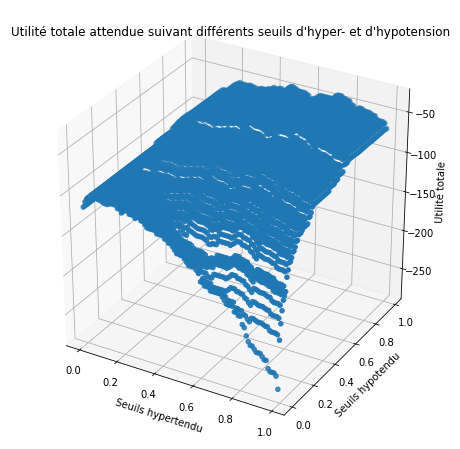

In [45]:
def graph_3D(n, S, posterior, minhyper, maxhyper, minhypo, maxhypo):
  """
  Crée les vecteurs x (vecteur des seuils pour l'hypertension), y (vecteur des seuils
  pour l'hypotension) et z (utilité totale associée à chaque couple de seuils) afin
  de pouvoir plotter un graphe 3D

  Arguments:
    S (numpy array): vecteur des états réels pour chaque pas de temps
    n (float): nombre de jours
    posterior (numpy array): arrays de probabilités postérieures
    minhyper (float): seuil minimal à analyser pour l'hypertension 
    maxhyper (float): seuil maximal à analyser pour l'hypertension 
    minhypo (float): seuil minimal à analyser pour l'hypotension  
    maxhypo (float): seuil minimal à analyser pour l'hypotension 

  Retourne:
    x1 (nympy array): vecteur des valeurs possibles pour le seuil d'hypertension
    y1 (nympy array): vecteur des valeurs possibles pour le seuil d'hypotension
    u (nympy array): vecteur des utilités totales pour chaque couple de seuils
  """
  hyporange = np.arange(minhypo, maxhypo, 0.01)
  hyperrange = np.arange(minhyper, maxhyper, 0.01)
  u = []
  x1 = []
  y1 = []
  for i in hyperrange:
    for j in hyporange:
      utility, cost = utilityandcost(S, n, posterior, i, j)
      x1.append(i)
      y1.append(j)
      u.append(np.sum(utility)-cost)
  return x1, y1, u


#Plot du graphique en 3D
fig = plt.figure(1,figsize=(8,8))
ax = fig.gca(projection='3d')                         # Affichage en 3D
x, y, z = graph_3D(100, S_training, posterior_probs, 0, 1, 0, 1)  #Création des vecteurs nécessaires pour plotter le graphique en 3D
p=ax.scatter(np.array(x), np.array(y), np.array(z))   #Tracé de la courbe 3D
plt.title("Utilité totale attendue suivant différents seuils d'hyper- et d'hypotension")
ax.set_xlabel('Seuils hypertendu')
ax.set_ylabel('Seuils hypotendu')
ax.set_zlabel('Utilité totale')

plt.show()

Ce graphe en 3 dimensions montre l’utilité totale associée aux différentes combinaisons de seuils. On peut voir qu'il peut y avoir de grandes différences d'utilité totale en fonction de la politique choisie. En effet, l'utilité totale varie entre environ -50 à environ -250, ce qui représente une différence importante.

L utilité maximale est de: -38.599999999999994
Elle apparait pour les seuils d hypertension et d hypotension respectivement suivants: 0.74 et 0.62


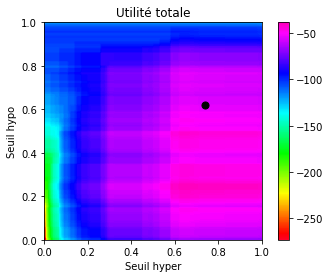

In [46]:
def color_map(n, S, posterior, minhyper, maxhyper, minhypo, maxhypo):
  """
  Crée une matrice de l'utilité totale en fonction des seuils 

  Arguments:
    S (numpy array): vecteur des états réels pour chaque pas de temps
    n (float): nombre de jours
    posterior (numpy array): arrays de probabilités postérieures
    minhyper (float): seuil minimal à analyser pour l'hypertension 
    maxhyper (float): seuil maximal à analyser pour l'hypertension 
    minhypo (float): seuil minimal à analyser pour l'hypotension  
    maxhypo (float): seuil minimal à analyser pour l'hypotension 

  Retourne:
    u (nympy array): matrice des utilités totales pour chaque combinaison de seuil
  """
  hyporange = np.arange(minhypo, maxhypo, 0.01)
  hyperrange = np.arange(minhyper, maxhyper, 0.01)
  u = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      utility, cost = utilityandcost(S, n, posterior, hyperrange[i], hyporange[j])
      u[i][j] = np.sum(utility) - cost
  return u



def getIndex(n, minhyper, maxhyper, minhypo, maxhypo, matrice, value):
  """
  Recherche les indexes (donc la valeur des seuils d'hyper- et d'hypotension) pour 
  lesquelles l'utilité totale équivaut à une certaine valeur (=value) 

  Arguments:
    n (float): nombre de jours
    minhyper (float): seuil minimal à analyser pour l'hypertension 
    maxhyper (float): seuil maximal à analyser pour l'hypertension 
    minhypo (float): seuil minimal à analyser pour l'hypotension  
    maxhypo (float): seuil minimal à analyser pour l'hypotension 
    matrice (numpy array): matrice dans laquelle on veut trouver la valeur 
    value (float): valeur qu'on souhaite trouver dans la matrice

  Retourne:
    hyperrange[i] (float): indice/seuil d'hypertension qui donne la valeur recherchée
    hyperrange[j] (float): indice/seuil d'hypotension qui donne la valeur recherchée
  """
  hyporange = np.arange(minhypo, maxhypo, 0.01)
  hyperrange = np.arange(minhyper, maxhyper, 0.01)
  for i in range(n):
    for j in range(n):
      if matrice[i][j] == value:
        return hyperrange[i], hyporange[j]


#Création et plot de la colormap
z = color_map(100, S_training, posterior_probs, 0, 1, 0, 1)  
u = np.array(z)
print('L utilité maximale est de:', np.max(u))       #donne la valeur de l'utilité totale maximale pour laquelle on voudra connaitres les index
index1, index2 = getIndex(100, 0,1,0,1,u, np.max(u)) #obtentions des index (=seuils) qui correspondent à la valeur d'utilité totale maximale
print('Elle apparait pour les seuils d hypertension et d hypotension respectivement suivants:', index1, 'et', index2)
plt.figure()
to_plot = pd.DataFrame(u)
plt.imshow(to_plot, cmap= 'gist_rainbow', extent = [0,1,0,1])
plt.title('Utilité totale')
plt.ylabel('Seuil hypo')
plt.xlabel('Seuil hyper')
plt.colorbar()
plt.scatter(index1, index2, marker='o', s=50, color='black')
plt.show()

Ce graphe est sans doute plus parlant pour évaluer l’évolution de la valeur de l’utilité totale associée aux différentes combinaisons de seuils. Nous pouvons bien vérifier ici que l’utilité maximale (représentée par le point noir sur la colormap) a comme valeur -38.59, comme nous l’avions déterminé au départ, sur base des seuils optimaux. Cela correspond bien aux seuils (0.74, 0.62) pour l’hypertension et de l’hypotension respectivement. 

# **Section 3: Discussion des résultats**

In [47]:
def etats(n, posterior, seuilA, seuilB):
  """
  Définit l'état supposé du patient pour chaque jour et crée un vecteur des états
  avec les tensions correspondants à chaque état 

  Arguments:
    n (float): nombre de jours
    posterior (numpy array): arrays de probabilités postérieures 
    seuilA (float): seuil choisi pour l'hypertension 
    seuilB (float): seuil choisi pour l'hypotension

  Retourne:
    etats (numpy array): vecteur reprenant nos prédictions des états sous forme de
    tensions (80 = hypotendu, 120= sain, 160 = hypertendu)
  """
  etats = np.zeros(n)
  i=0
  for i in range(n):
      if posterior[i, 1] > seuilA:    #hypertendu si postérieur supérieur au seuil A
        etats[i] = 160                #le patient est consideré comme hypertendu donc on a évalue sa tension à 160 mmHg
      elif posterior[i, 2] > seuilB:  #hypotendu si postérieur supérieur au seuil B
        etats[i] = 80                 #tension évaluée à 80 mmHg
      else:                           #sain
        etats[i] = 120                #tension évaluée à 120 mmHg
  return etats

states = etats(150, posterior_probs, optimaltresh1, optimaltresh2)

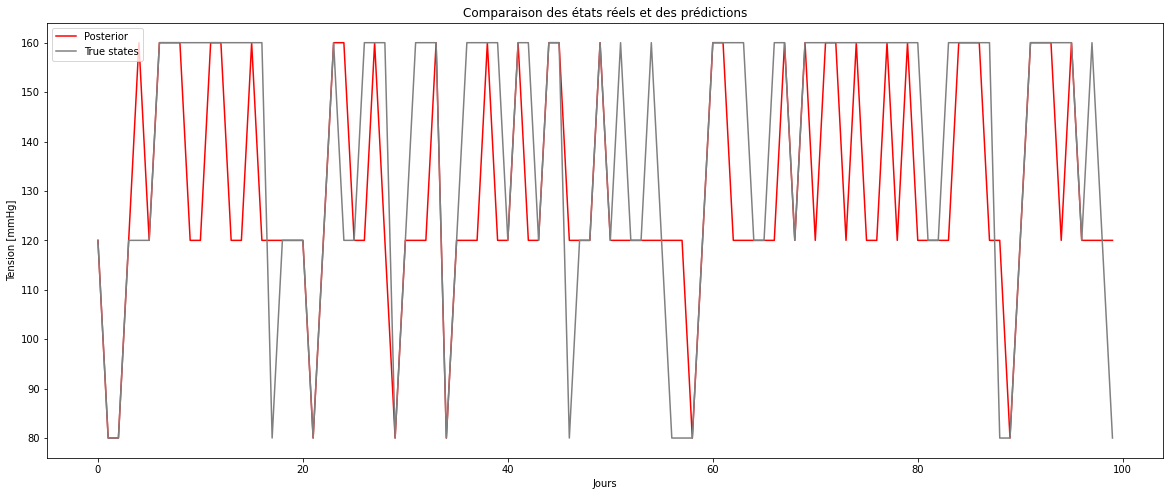

Les 2 vecteurs sont égaux 64 fois. Cela signifie donc que 64 % des prédictions sont bonnes


In [48]:
#transformation du vecteur contenant les états réels S en tensions afin de pouvoir comparer avec nos postérieurs
jour1 = np.arange(0,100,1)
s = np.zeros(len(jour1))
for i in jour1:
  if S_training[i] == 'healthy':
    s[i] = 120
  elif S_training[i] == 'hyper':
    s[i] = 160
  else:
    s[i] = 80


#Plot du graphe qui compare les états réels avec les états prédits 
fig = plt.figure(1,figsize=(20,8))
ax = fig.add_subplot(111)
states1=states[0:100]
plt.plot(jour1, states1, color='red', label='Posterior')
plt.plot(jour1, s, color='grey', label='True states')
ax.set_title('Comparaison des états réels et des prédictions')
ax.set_xlabel('Jours')
ax.set_ylabel('Tension [mmHg]')
plt.legend()
plt.show()


#k est incrémenté lorsque la prédiction correspond à l'état réel. Ceci permet de calculer le pourcentage de correspondance entre les états réels et nos prédictions
k=0
for i in range(100):
  if s[i]==states[i]:
    k+=1
  else:
    k=k

print('Les 2 vecteurs sont égaux',k, 'fois. Cela signifie donc que', k,'% des prédictions sont bonnes')

Ce graphique affiche les prédictions des états du patient basés sur les probabilités postérieures calculées ainsi que les états réels afin d'évaluer la fiabilité de la politique choisie. On peut voir que la majorité des états sont similaires entre les vraies mesures et les prédictions (notamment, 64% des états sont identiques). Cependant, cela laisse encore un taux d'erreurs non-négligeable, à savoir 33%.

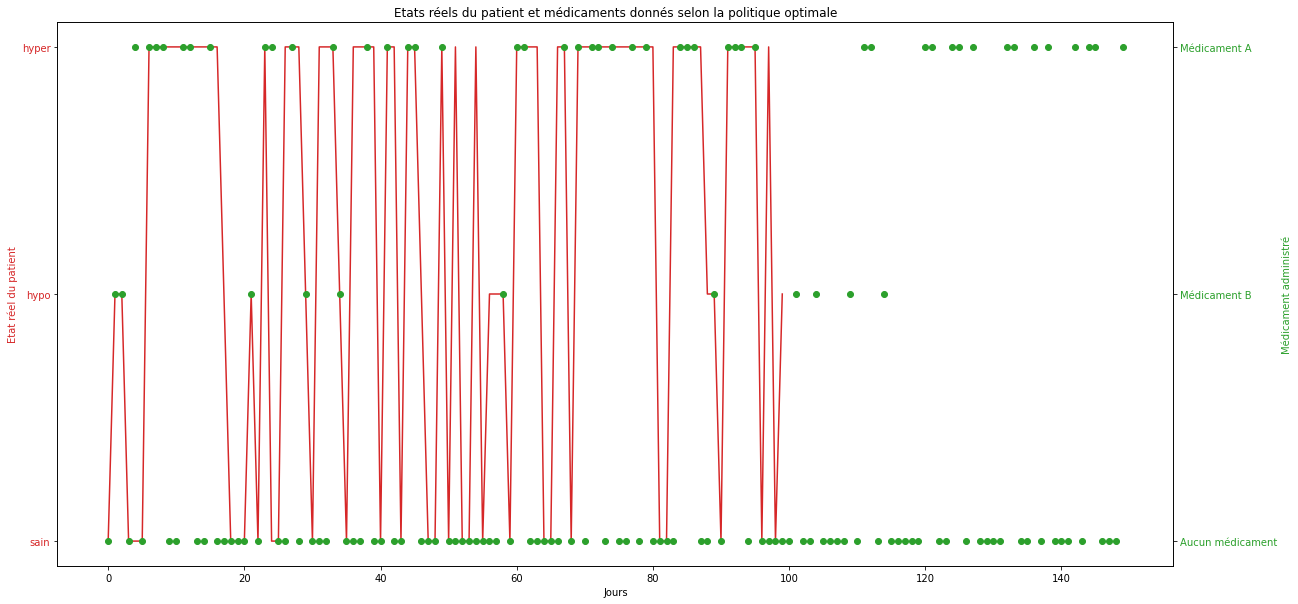

In [49]:
#conversion du vecteur actions sous forme de vecteur contenant les string : "Médicament A", "Médicament B", "Aucun médicament"
jours = np.arange(0, 150, 1)
medocs = action(150, posterior_probs, optimaltresh1, optimaltresh2)
actions_taken = []
for i in range(len(jours)):
  if medocs[i] == -1:
    actions_taken.append('Médicament B')
  elif medocs[i] == 0:
    actions_taken.append('Aucun médicament')
  else:
    actions_taken.append('Médicament A')


#transformation du vecteur contenant les états réels S en français
s = []
for i in jour1:
  if S_training[i] == 'healthy':
    s.append('sain')
  elif S_training[i] == 'hyper':
    s.append('hyper')
  else:
    s.append('hypo')


#plot du graphe à double axe y pour comparer les états réels avec les actions prises sous notre politique
sjours = np.arange(0,100,1) 
dataset_1 =  s
dataset_2 = actions_taken 
  
fig, ax1 = plt.subplots(figsize=(20,10))  
color = 'tab:red'
ax1.set_xlabel('Jours')  
ax1.set_ylabel('Etat réel du patient', color = color)  
ax1.plot(sjours, dataset_1, color = color)  
ax1.tick_params(axis ='y', labelcolor = color)  
ax2 = ax1.twinx()  
  
color = 'tab:green'
ax2.set_ylabel('Médicament administré', color = color)  
ax2.scatter(jours, dataset_2, color = color)  
ax2.tick_params(axis ='y', labelcolor = color)  
  
plt.title('Etats réels du patient et médicaments donnés selon la politique optimale')  
  
plt.show()

Ce graphique montre les médicaments administrés sous la politique choisie par rapport aux états réels du patient. Sur l’axe des y à gauche, on a les 3 états possibles du patient (représentés par les courbes rouges) et sur l’axe y de droite, les différents médicaments administrés (représentés par des points verts). On peut voir que dans la majorité des cas, s’il faut donner un médicament, celui-ci est donné. Cependant, on peut remarquer qu'il arrive qu'aucun médicament ne soit donné alors que le patient en avait besoin (car il souffrait à ce moment d'hypo- ou d'hypertension) ou encore qu'un médicament soit administré alors que le patient était sain. 

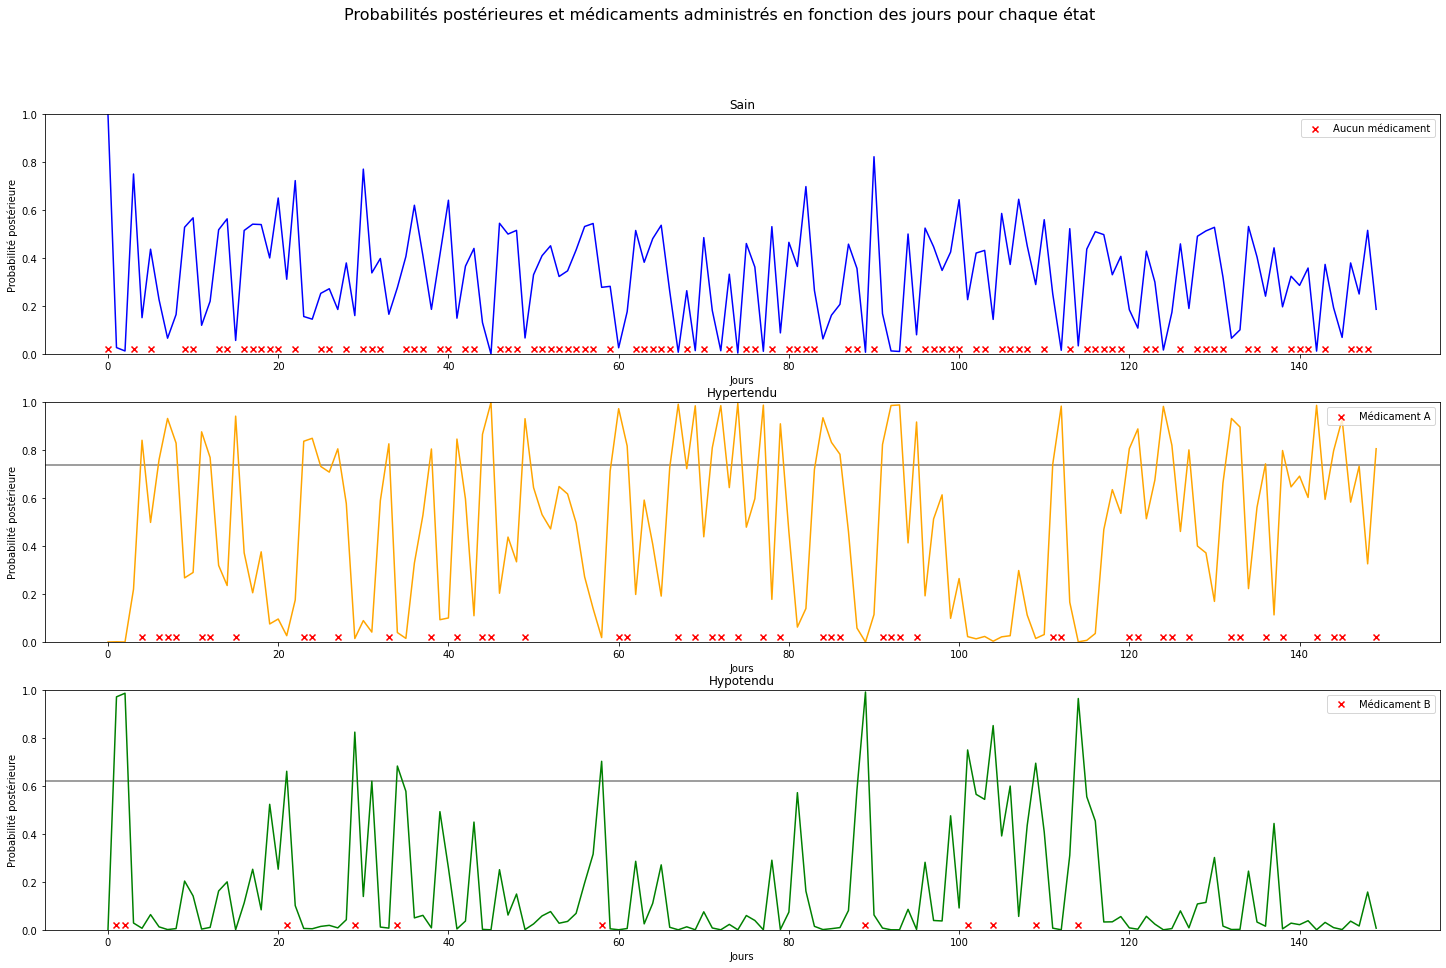

In [50]:
#création de vecteurs comportant quels jours le médicament (ou rien) a été administré
medocs = action(150, posterior_probs, optimaltresh1, optimaltresh2)
medocA =[]                #vecteur qui contiendra les jours où le médicament A a été administré
medocB=[]                 #vecteur qui contiendra les jours où le médicament B a été administré
rien=[]                   #vecteur qui contiendra les jours où aucun médicament n'a été administré

for i in range(len(jours)):
  if medocs[i] == -1:
    medocB.append(i)
  elif medocs[i] == 0:
    rien.append(i)
  else:
    medocA.append(i)

yrien = [0.02]*len(rien)      #vecteurs y pour pouvoir plotter les vecteurs ci-dessus
ymedocA = [0.02]*len(medocA)
ymedocB = [0.02]*len(medocB)


#Plot des graphiques reprenant les postérieurs calculés ainsi que les médicaments administrés pour chaque état (sain, hypertendu et hypotendu)
fig = plt.figure(1,figsize=(25,15))
fig.suptitle('Probabilités postérieures et médicaments administrés en fonction des jours pour chaque état', fontsize=16)

ax1=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2)
ax3=fig.add_subplot(3,1,3)

ax1.set_title("Sain")
ax1.set_ylabel('Probabilité postérieure')
ax1.set_xlabel('Jours')
ax1.set_ylim(0,1)
ax1.plot(days, posterior_probs[:,0], color='blue')
ax1.scatter(rien, yrien, marker='x', label='Aucun médicament', color='red')
ax1.legend()

ax2.set_title("Hypertendu")
ax2.set_ylabel('Probabilité postérieure')
ax2.set_xlabel('Jours')
ax2.set_ylim(0,1)
ax2.axhline(y=optimaltresh1, color='grey', linestyle='-')
ax2.plot(days, posterior_probs[:,1], color='orange')
ax2.scatter(medocA, ymedocA, marker='x',label='Médicament A', color='red')
ax2.legend(loc='upper right')

ax3.set_title("Hypotendu")
ax3.set_ylabel('Probabilité postérieure')
ax3.set_xlabel('Jours')
ax3.set_ylim(0,1)
ax3.axhline(y=optimaltresh2, color='grey', linestyle='-')
ax3.plot(days, posterior_probs[:,2], color='green')
ax3.scatter(medocB, ymedocB, marker='x',label='Médicament B', color='red')
ax3.legend()

Ces graphes montrent les postérieurs pour chaque état, ainsi que les médicaments que l’on donne, sur base de la politique que nous avons déterminée ci-dessus. On voit bien que dès que la probabilité postérieure est au-dessus des seuils déterminés d'hyper- ou d'hypotesion, le médicament A ou B, selon les cas, est donné. 

Ce graphe permet aussi d’expliquer pourquoi le médicament adéquat n’est pas toujours donné et pourquoi dans certains cas, un médicament est donné alors que le patient est sain comme nous pouvions l’observer dans le graphique ci-dessus ("Etats réels du patient et médicaments donnés selon la politique optimale"). En effet, pour le jour 4 par exemple, on voit que le médicament A est donné parce que la probabilité postérieure de l’état hypertendu est supérieure au seuil (qui est de 0.74). Selon la politique définie, vu que le seuil est dépassé, le patient est considéré comme hypertendu et en conséquence, le médicament A réduisant la tension lui est administré. Cependant, lorsque nous regardons aux états réels, au quatrième jour, le patient était sain. Ce genre de cas peut également être observé pour d'autres jours.


Nous pouvons en conclure que, bien que notre politique maximise l'utilité totale, elle ne permet pas de déterminer avec exactitude l'état réel du patient. On pose l'hypothèse que cela est dû au fait que, bien qu'on utilise en partie les mesures, on utilise des valeurs de probabilités (notamment dans la matrice de transition) purement théoriques qui nous permettent de nous approcher de la réalité, mais qui ne sont probablement pas toujours pertinentes. Le corps humain est en effet un système dynamique très complexe, les probabilités peuvent donc changer au cas par cas, et également au fil du temps. 


In [51]:
print('Les médicaments administrés les 50 derniers jours sont les suivants:', medocs[100:150])
print('0 correspond à aucun médicament administré')
print('1 correspond à l administration du médicament A')
print('-1 correspond à l administration du médicament B')

Les médicaments administrés les 50 derniers jours sont les suivants: [ 0. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0.  1.  1.  0. -1.  0.  0.  0.
  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.]
0 correspond à aucun médicament administré
1 correspond à l administration du médicament A
-1 correspond à l administration du médicament B


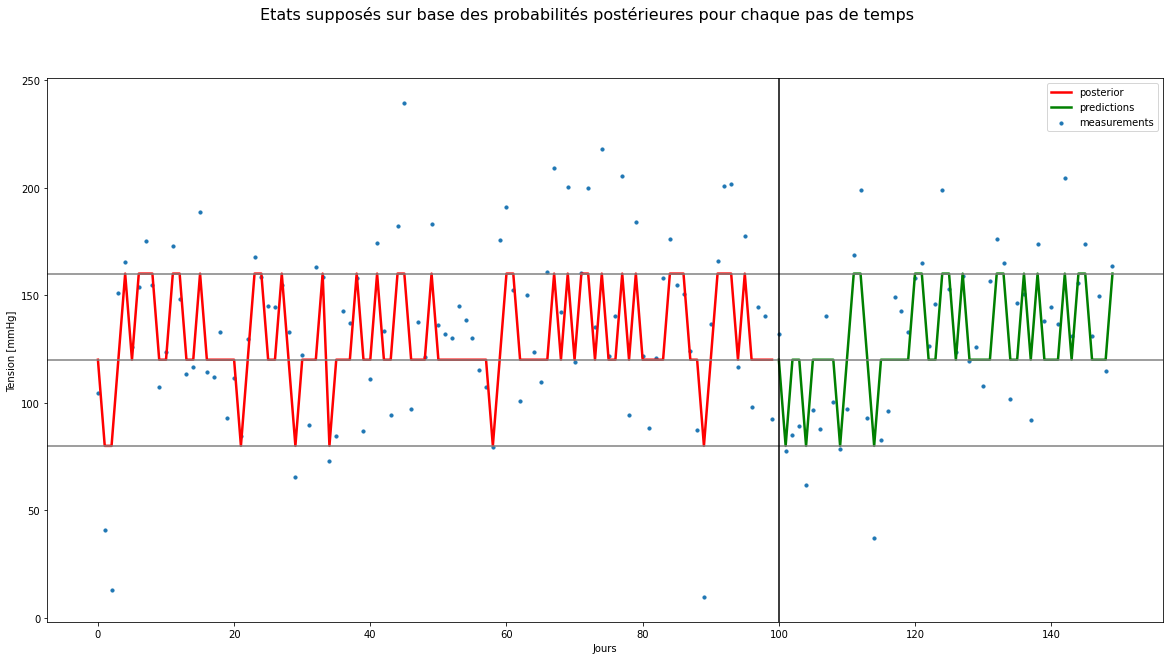

In [52]:
jour1=np.arange(0,100,1)        #vecteurs pour l'axe des x
jour2=np.arange(100,150,1)

#plot du graphique 
fig = plt.figure(1,figsize=(20,10))
fig.suptitle('Etats supposés sur base des probabilités postérieures pour chaque pas de temps', fontsize=16)
ax = fig.add_subplot(111)
states1=states[0:100]                   #reprend les 100 premiers états définis sur base de nos postérieurs (qui ont pu être comprés aux états réels)
states2=states[100:150]                 #reprend les 50 derniers états définis sur base de nos postérieurs (qui n'ont pas pu être comparés aux états réels)
plt.plot(jour1, states1, linewidth = 2.5, color='red', label='posterior')
plt.plot(jour2, states2, linewidth = 2.5, color='green', label='predictions')
plt.axhline(y=120, color='grey', linestyle='-')
plt.axhline(y=80, color='grey', linestyle='-')
plt.axhline(y=160, color='grey', linestyle='-')
plt.axvline(x=100, color='black')
plt.scatter(jours, measurements, s=10, label='measurements')
ax.set_xlabel('Jours')
ax.set_ylabel('Tension [mmHg]')
plt.legend()
plt.show()

La courbe rouge montre l’évolution de la tension selon les postérieurs que nous avons calculés pour les 100 premiers états tandis que la courbe verte montre l’évolution de la tension pour les 50 derniers états, ceux pour lesquels nous n’avons plus l’état réel du patient. Cette courbe représente donc les prédictions faites grâce aux postérieurs. Les points bleus montrent les mesures de tension du patient contenues dans le vecteur M. Les valeurs de référence concernant l’hypotension, l’état sain et l’hypertension sont 80, 120, 160 mmHg respectivement (ce qui correspond donc aux droites grises horizontales).

Il est important de noter que nous avons défini les états (sain, hyper- ou hypotendu) sur base des valeurs théoriques fournies (120, 160 ou 80 mmHg). Cependant, en pratique, la tension du patient ne se trouvera pas exactement à ces valeurs (ceci peut d'ailleurs être observé sur le graphique).

On peut remarquer que lorsque les points (mesures) se trouvent environ au milieu entre deux états, il est difficile de conclure de l'état réel étant donné qu'il n'y a pas de limite intermédiaire bien définie à partir de laquelle on peut identifier le patient comme étant hyper- ou hypotendu. En effet, les distributions normales des pressions artérielles systoliques (m_t) se superposent, ce qui fait qu'il n'y a pas une sureté absolue sur l'état du patient, contrairement aux valeurs théoriques (80,120,160).

**4. Discussion à propos de l'impact des paramètres du modèle sur la politique et les actions en résultant**

Les données de coût et d’utilité sont dans le même range de valeurs (aux alentours de 2) et ont donc plus ou moins la même influence sur l’utilité totale, prenant en compte le coût et l’utilité, qui doit donc être maximisée.


On peut se demander comment la politique évoluerait si les coûts des médicaments augmentaient. Selon nous, sachant que les coûts ont un impact négatif sur l’utilité totale, si le coût des médicaments augmente mais que l’utilité (par rapport aux états) reste identique, les seuils optimaux seront plus grands. En effet, traiter un patient diminuerait fortement l’utilité totale puisque le coût aurait plus de poids par rapport à l'utilité. Or, comme le but de la politique optimale est de maximiser l'utilité totale, elle aura tendance à privilégier l'abstinence de médicaments. Elle identifierait alors un patient comme malade pour des valeurs de seuils plus significatifs.


A l’inverse, si les coûts étaient plus faibles, les seuils optimaux seraient plus bas, puisque traiter un patient n’aurait pas un impact significatif sur l’utilité.

Si par contre on accorde plus de poids aux valeurs d'utilité, les seuils auront tendance à être plus bas. En effet, le principal serait d'identifier correctement l'état du patient afin de pouvoir lui administrer le traitement correct. De plus, comme l'utilité aura un impact plus significatif que le coût, on aura moins tendance à vouloir éviter d'administrer un médicament.